## Кредитный скоринг
Датасет содержит информацию о клиентах некоторого банка.

#### Цель: по различным характеристикам клиентов спрогнозировать целевую переменную - имел клиент просрочку 90 и более дней или нет (и если имел, то банк не будет выдавать кредит этому клиенту, а иначе будет).

Целевая переменная (таргет) – SeriousDlqin2yrs: клиент имел просрочку 90 и более дней

Признаки:

RevolvingUtilizationOfUnsecuredLines: общий баланс средств (total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits)

age: возраст заемщика

NumberOfTime30-59DaysPastDueNotWorse: сколько раз за последние 2 года наблюдалась просрочка 30-59 дней

DebtRatio: ежемесячные расходы (платеж по долгам, алиментам, расходы на проживания) деленные на месячный доход

MonthlyIncome: ежемесячный доход

NumberOfOpenCreditLinesAndLoans: количество открытых кредитов (напрмер, автокредит или ипотека) и кредитных карт

NumberOfTimes90DaysLate: сколько раз наблюдалась просрочка (90 и более дней)

RealEstateLoansOrLines: закодированное количество кредитов (в том числе под залог жилья) - чем больше код буквы, тем больше кредитов

NumberOfTime60-89DaysPastDueNotWorse: сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней

NumberOfDependents: количество иждивенцев на попечении (супруги, дети и др)

GroupAge: закодированная возрастная группа - чем больше код, тем больше возраст

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, recall_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

## Анализ и предобработка данных

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/valeria-khmelenko/credit_scoring/main/credit_scoring.csv')

Размер датасета

In [3]:
df.shape

(150000, 12)

In [4]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
0,0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0,A,c
1,0,0.602794,25.0,0,0.065868,333.0,2,0,0,0.0,A,b
2,1,0.025656,38.0,0,0.475841,3000.0,7,0,0,2.0,A,c
3,0,0.075427,32.0,0,0.085512,7916.0,6,0,0,0.0,A,b
4,0,0.046560,58.0,0,0.241622,2416.0,9,0,0,0.0,A,d


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   135155 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 9   NumberOfDependents                    146076 non-null  float64
 10  RealEstateLoansOrLines                150000 non-null  object 
 11  

Количество пропусков в данных для каждого признака

In [6]:
display('Доля пропущенных значений до обработки:')
display(pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm'))

'Доля пропущенных значений до обработки:'

,0
SeriousDlqin2yrs,0.000000
RevolvingUtilizationOfUnsecuredLines,0.000000
age,10.000000
NumberOfTime30-59DaysPastDueNotWorse,0.000000
DebtRatio,0.000000
MonthlyIncome,20.000000
NumberOfOpenCreditLinesAndLoans,0.000000
NumberOfTimes90DaysLate,0.000000
NumberOfTime60-89DaysPastDueNotWorse,0.000000
NumberOfDependents,3.000000


Промежуточный вывод: отсутствует большая доля данных (20%) по ежемесячному доходу, а также данные по возрасту клиентов (10%) по количеству иждивенцев (3%).

In [7]:
df.describe(include='all')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
count,150000.000000,150000.000000,135155.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,146076.000000,150000,150000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,d
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140048,47268
mean,0.066840,6.048438,52.293618,0.421033,353.005076,6.670221e+03,8.452760,0.265973,0.240387,0.757222,NaN,NaN
std,0.249746,249.755371,14.772577,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,4.155179,1.115086,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,0.000000,1.000000,NaN,NaN


In [8]:
df.dropna(subset=['age', 'MonthlyIncome'], inplace=True)

In [9]:
display('Доля пропущенных значений после обработки:')
display(pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm'))

'Доля пропущенных значений после обработки:'

,0
SeriousDlqin2yrs,0.000000
RevolvingUtilizationOfUnsecuredLines,0.000000
age,0.000000
NumberOfTime30-59DaysPastDueNotWorse,0.000000
DebtRatio,0.000000
MonthlyIncome,0.000000
NumberOfOpenCreditLinesAndLoans,0.000000
NumberOfTimes90DaysLate,0.000000
NumberOfTime60-89DaysPastDueNotWorse,0.000000
NumberOfDependents,0.000000


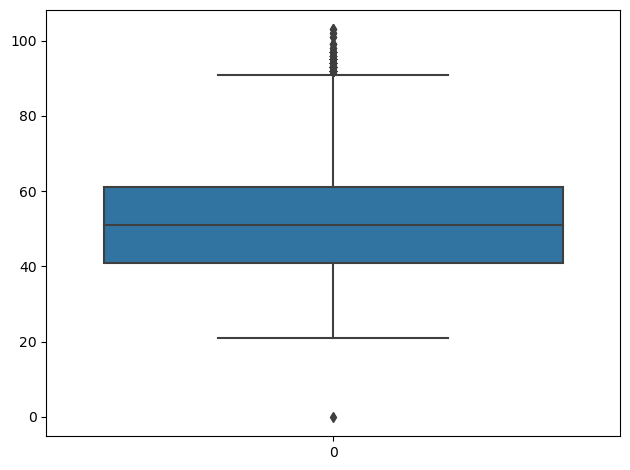

In [10]:
sns.boxplot(df['age'])
plt.tight_layout()

In [11]:
df = df.loc[df['age'] > 0]
df = df.loc[df['age'] < 90]

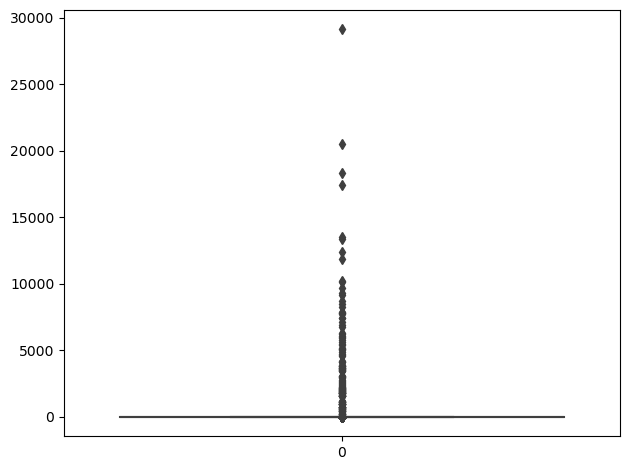

In [12]:
sns.boxplot(df['RevolvingUtilizationOfUnsecuredLines'])
plt.tight_layout()

In [13]:
df = df.loc[df['RevolvingUtilizationOfUnsecuredLines'] < 10_000]

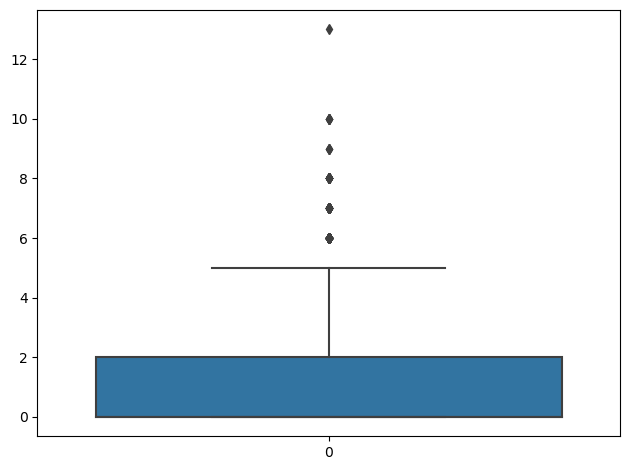

In [14]:
sns.boxplot(df['NumberOfDependents'])
plt.tight_layout()

In [15]:
df = df.loc[df['NumberOfDependents'] < 6]

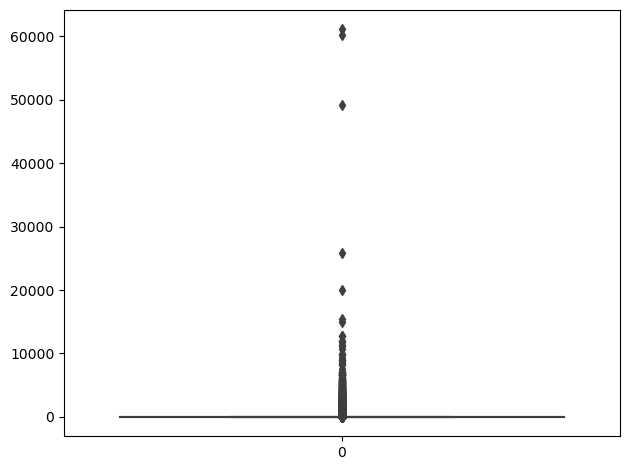

In [16]:
sns.boxplot(df['DebtRatio'])
plt.tight_layout()

In [17]:
df = df.loc[df['DebtRatio'] < 10_000]

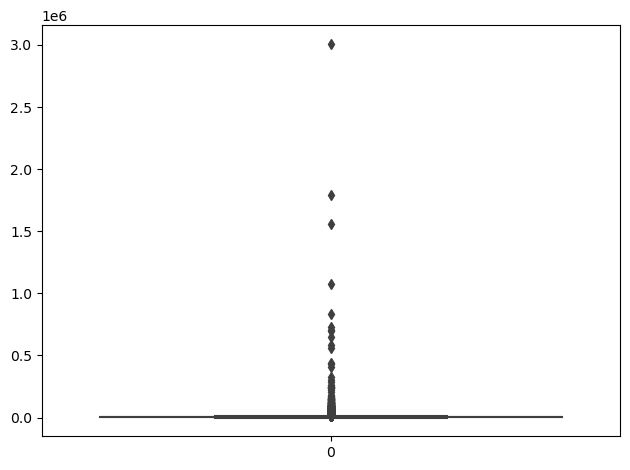

In [18]:
sns.boxplot(df['MonthlyIncome'])
plt.tight_layout()

In [19]:
max_income = df['MonthlyIncome'].max()

In [20]:
df['MonthlyIncome'].mean()

6683.496185968819

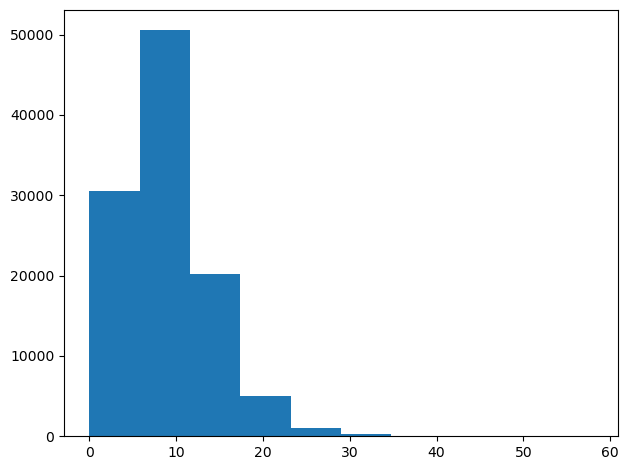

In [21]:
plt.hist(df['NumberOfOpenCreditLinesAndLoans'])
plt.tight_layout()

In [22]:
df['NumberOfOpenCreditLinesAndLoans'].describe()

count    107760.000000
mean          8.761591
std           5.171969
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [23]:
df = df.loc[df['NumberOfOpenCreditLinesAndLoans'] < 25]

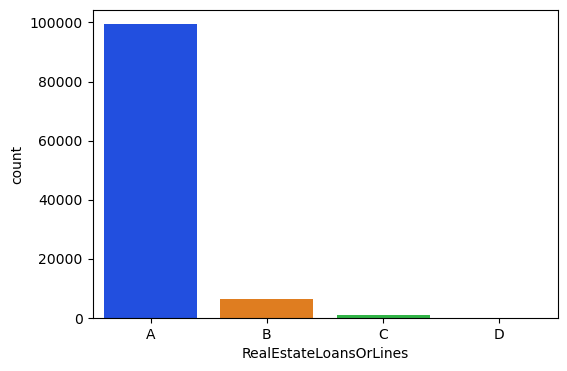

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(x='RealEstateLoansOrLines', data = df, palette='bright')
plt.show()

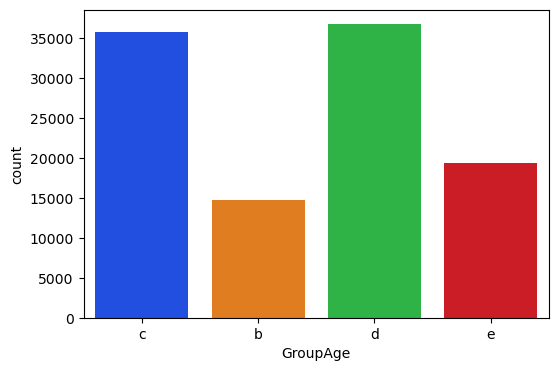

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(x='GroupAge', data = df, palette='bright')
plt.show()

Добавим в модель новые признаки на основании имеющихся

In [26]:
df['NumberOfTime30-89DaysPastDueNotWorse'] = df['NumberOfTime30-59DaysPastDueNotWorse'] + df['NumberOfTime60-89DaysPastDueNotWorse']

In [27]:
df['MonthlyExpenses'] = df['MonthlyIncome'] * df['DebtRatio']

In [28]:
df['OverdueRatio'] = df['NumberOfTimes90DaysLate'] * df['NumberOfOpenCreditLinesAndLoans']

In [29]:
df['OverdueRatio'].describe()

count    106592.000000
mean          0.558654
std           3.743855
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         322.000000
Name: OverdueRatio, dtype: float64

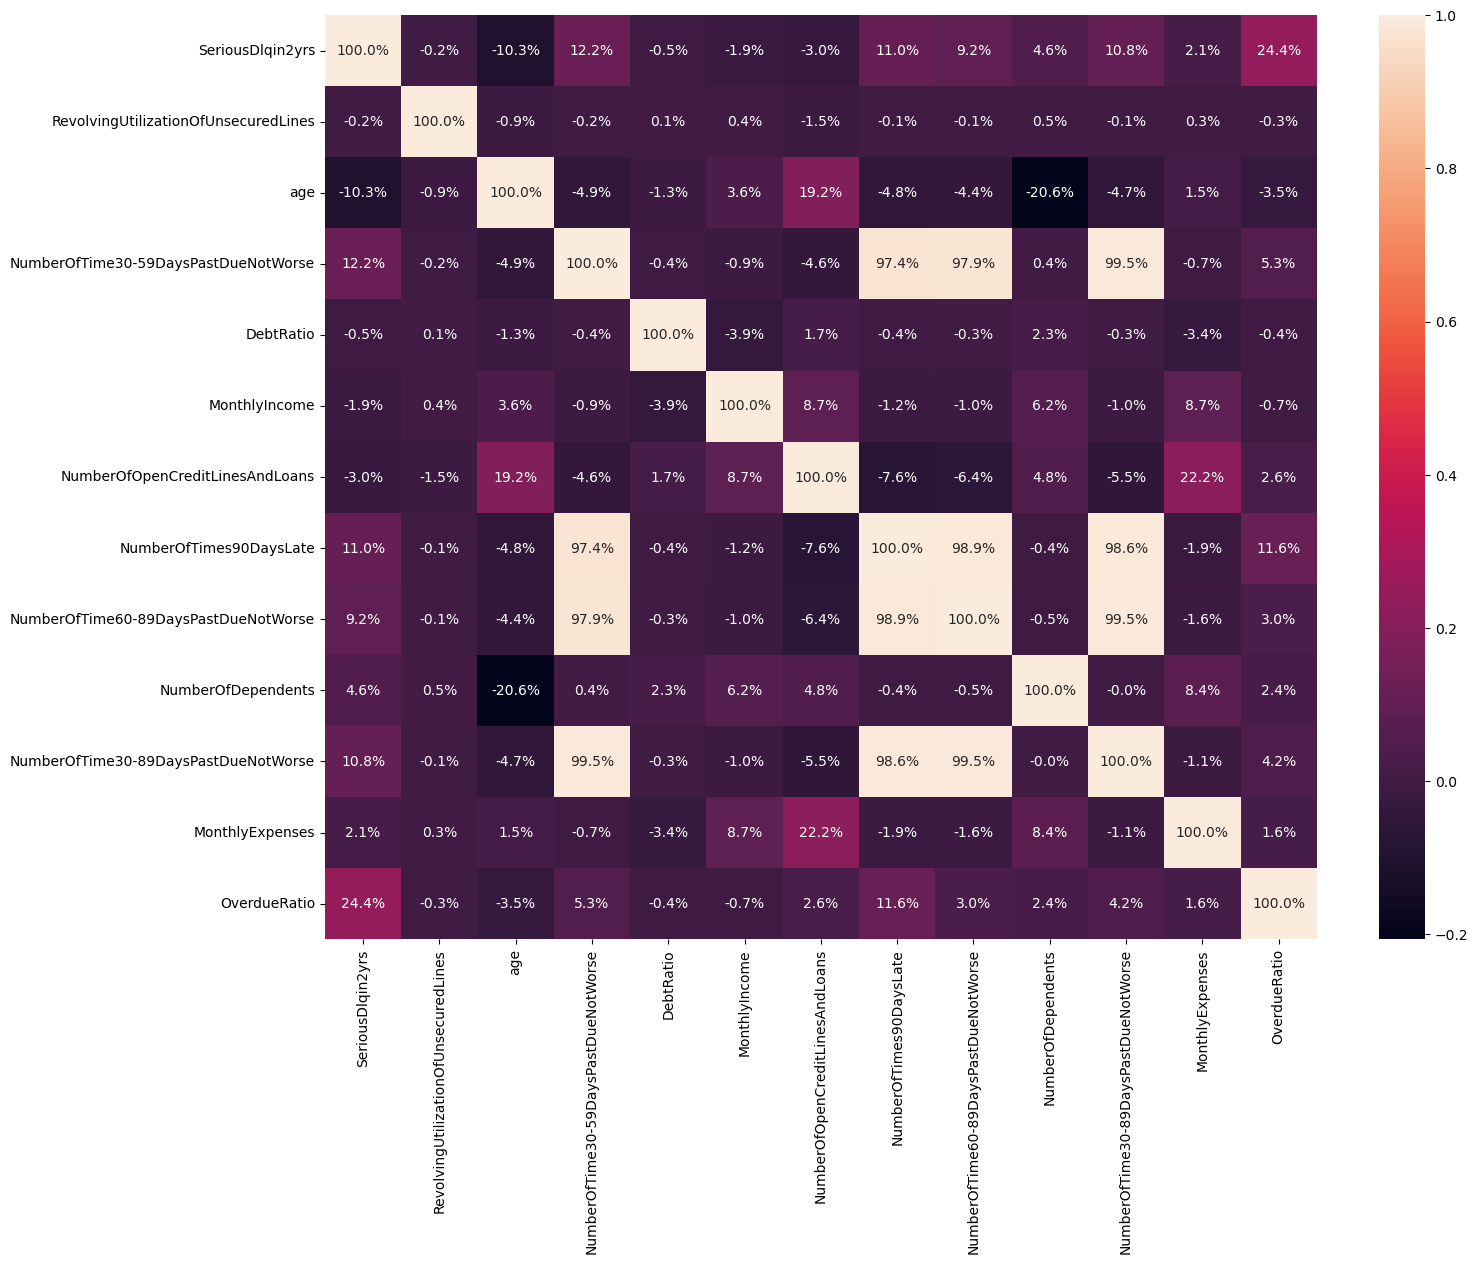

In [30]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr(), annot=True, fmt=".1%")
plt.show()

In [31]:
columns_to_drop = ['NumberOfTimes90DaysLate', 
                   'NumberOfTime60-89DaysPastDueNotWorse',
                   'NumberOfTime30-59DaysPastDueNotWorse',
                   'RealEstateLoansOrLines',
                   'GroupAge']

In [32]:
df.drop(labels=columns_to_drop, axis = 1, inplace=True)
df.shape

(106592, 10)

## Обучение моделей и выбор финальной модели

In [33]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,NumberOfTime30-89DaysPastDueNotWorse,MonthlyExpenses,OverdueRatio
0,0,0.221813,43.0,0.527888,3280.0,7,2.0,0,1731.472112,0
1,0,0.602794,25.0,0.065868,333.0,2,0.0,0,21.934132,0
2,1,0.025656,38.0,0.475841,3000.0,7,2.0,0,1427.524158,0
3,0,0.075427,32.0,0.085512,7916.0,6,0.0,0,676.914488,0
4,0,0.046560,58.0,0.241622,2416.0,9,0.0,0,583.758378,0


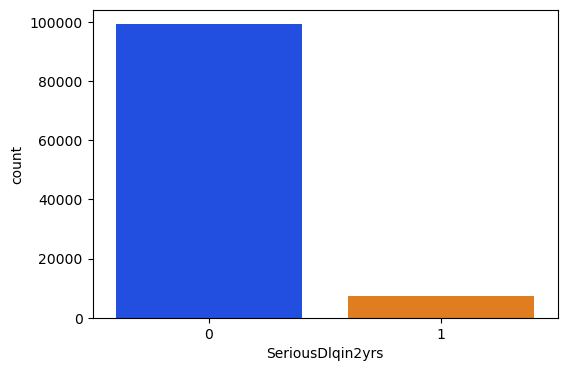

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(x='SeriousDlqin2yrs', data = df_ohe, palette='bright')
plt.show()

In [35]:
RANDOM_STATE = 12345

Промежуточный вывод: наблюдается дисбаланс классов в целевой переменной

In [36]:
target = df_ohe['SeriousDlqin2yrs']
features = df_ohe.drop('SeriousDlqin2yrs', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, stratify=target, test_size=0.25, random_state=RANDOM_STATE)

In [37]:
display(target_train.count())
display(target_test.count())

79944

26648

In [38]:
pd.options.mode.chained_assignment = None
numeric = ['RevolvingUtilizationOfUnsecuredLines', 
           'age', 
           'NumberOfTime30-89DaysPastDueNotWorse',
           'MonthlyExpenses',
           'DebtRatio',
           'OverdueRatio',
           'MonthlyIncome',
           'NumberOfOpenCreditLinesAndLoans',
           'NumberOfDependents']

scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
display(features_train.head())

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,NumberOfTime30-89DaysPastDueNotWorse,MonthlyExpenses,OverdueRatio
71534,-0.029316,-0.288153,-0.086566,-0.357678,-0.753041,1.028337,-0.083457,-0.247002,-0.157818
24704,-0.024405,1.250322,-0.087923,0.382436,-0.116489,-0.751973,0.222004,0.302119,2.107227
148098,-0.030793,-1.407043,-0.088557,0.673622,0.732249,0.138182,0.069274,-0.103274,-0.157818
117336,-0.030804,-1.127321,-0.088063,0.202013,0.095696,1.028337,-0.083457,0.039004,-0.157818
32943,-0.030524,0.131431,-0.087904,-0.119121,1.368802,0.138182,0.069274,-0.173706,-0.157818


In [39]:
target_train.value_counts(normalize = 1)

0    0.930639
1    0.069361
Name: SeriousDlqin2yrs, dtype: float64

In [40]:
target_test.value_counts(normalize = 1)

0    0.930651
1    0.069349
Name: SeriousDlqin2yrs, dtype: float64

In [41]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RANDOM_STATE)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [42]:
model_LR = LogisticRegression()

parametrs = {'C': np.logspace(-1, 3, 7), 
             'max_iter': range(100, 500, 20),
             'solver': ['newton-cholesky'],
             'penalty': ['l2', None],
             'class_weight': ['balanced'],
            'random_state': [RANDOM_STATE]}

random_search_lr = RandomizedSearchCV(model_LR, parametrs, scoring = 'roc_auc', cv = 5, random_state=RANDOM_STATE, n_jobs=-1)
model_LR = random_search_lr.fit(features_downsampled, target_downsampled)

print('Наилучшее значение roc_auc в модели LogisticRegression равно {} \n при следующих гиперпараметрах: {}'
      .format(random_search_lr.best_score_, random_search_lr.best_params_))

Наилучшее значение roc_auc в модели LogisticRegression равно 0.7934442779991662 
 при следующих гиперпараметрах: {'solver': 'newton-cholesky', 'random_state': 12345, 'penalty': None, 'max_iter': 360, 'class_weight': 'balanced', 'C': 0.46415888336127786}


In [43]:
model_DT = DecisionTreeClassifier()

parametrs = {'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': range(1, 20, 2),
            'random_state': [RANDOM_STATE]}

random_search_dt = RandomizedSearchCV(model_DT, parametrs, scoring = 'roc_auc', cv = 5, random_state=RANDOM_STATE, n_jobs=-1)
model_DT = random_search_dt.fit(features_downsampled, target_downsampled)

print('Наилучшее значение roc_auc в модели DecisionTreeClassifier равно {} \n при следующих гиперпараметрах: {}'
      .format(random_search_dt.best_score_, random_search_dt.best_params_))

Наилучшее значение roc_auc в модели DecisionTreeClassifier равно 0.8404173574953703 
 при следующих гиперпараметрах: {'random_state': 12345, 'max_depth': 5, 'criterion': 'entropy'}


In [44]:
model_RF = RandomForestClassifier()

parametrs = {'criterion': ['gini'],
             'n_estimators': range(100, 300, 50),
            'max_depth': range(1, 20, 2),
            'random_state': [RANDOM_STATE]}

random_search_rf = RandomizedSearchCV(model_RF, parametrs, scoring = 'roc_auc', cv = 5, random_state=RANDOM_STATE, n_jobs=-1)
model_RF = random_search_rf.fit(features_downsampled, target_downsampled)

print('Наилучшее значение roc_auc в модели RandomForestClassifier равно {} \n при следующих гиперпараметрах: {}'
      .format(random_search_rf.best_score_, random_search_rf.best_params_))

Наилучшее значение roc_auc в модели RandomForestClassifier равно 0.8550272331946829 
 при следующих гиперпараметрах: {'random_state': 12345, 'n_estimators': 250, 'max_depth': 9, 'criterion': 'gini'}


## Тестирование финальной модели

In [45]:
model_RF_final = RandomForestClassifier(random_state=RANDOM_STATE, max_depth = 9, n_estimators = 250, criterion= 'gini')
model_RF_final.fit(features_downsampled, target_downsampled)

RandomForestClassifier(max_depth=9, n_estimators=250, random_state=12345)

In [46]:
predicted_final = model_RF_final.predict(features_test)
print(roc_auc_score(target_test, predicted_final))

0.7634877286691802


In [47]:
probs = model_RF_final.predict_proba(features_test)
classes = probs[:, 1] > 0.4
print('Значение ROC_AUC на тестовой выборке', round(roc_auc_score(target_test, classes), 2))
print('Значение recall_score на тестовой выборке', round(recall_score(target_test, classes), 2))

Значение ROC_AUC на тестовой выборке 0.77
Значение recall_score на тестовой выборке 0.8


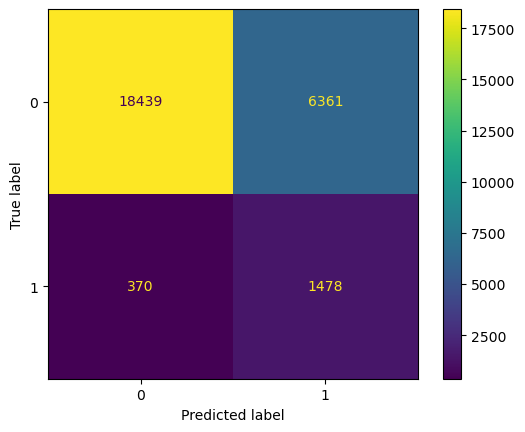

In [49]:
conf_matrix = confusion_matrix(target_test, classes, labels=model_RF_final.classes_)
matrix_image = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model_RF_final.classes_)

matrix_image.plot()
plt.show()

## Анализ важности признаков

In [50]:
feat_imp = pd.DataFrame({'Value': model_RF_final.feature_importances_,'Feature':features.columns.tolist()}).sort_values(by="Value",ascending=False)

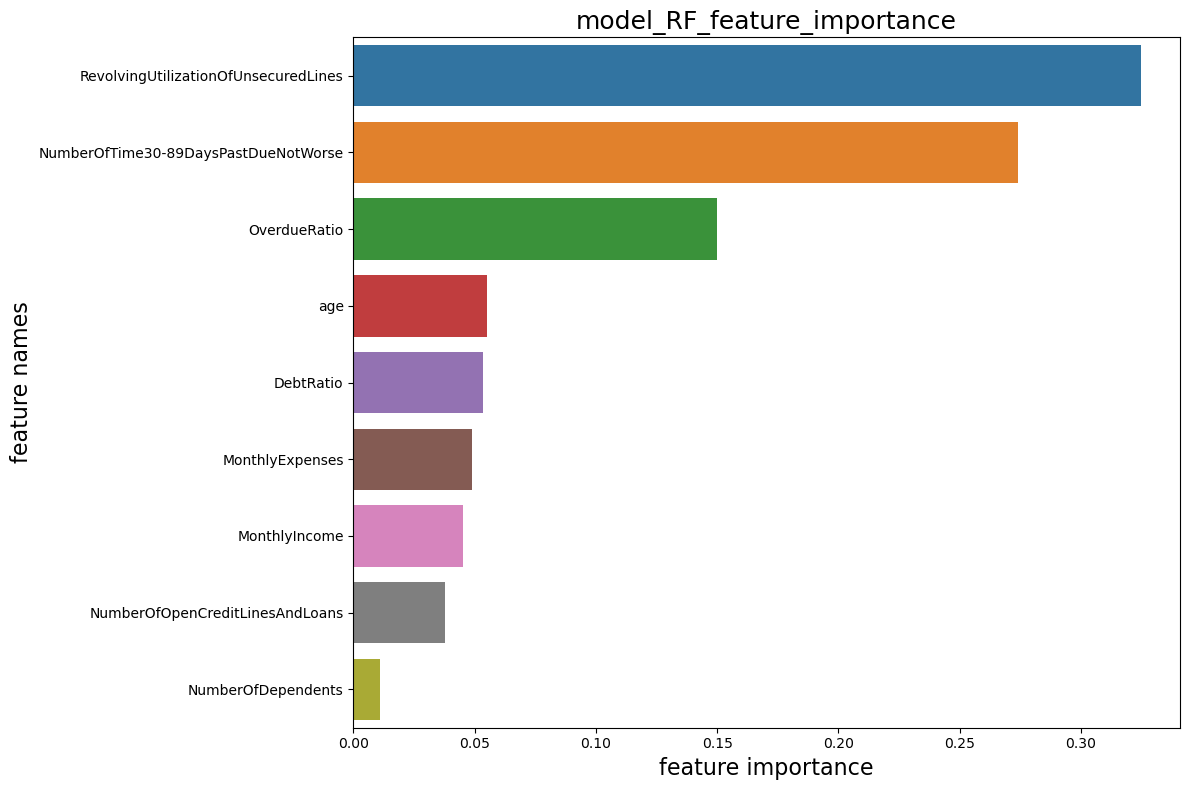

In [51]:
plt.figure(figsize=(12,8))

sns.barplot(y=feat_imp['Feature'], x=feat_imp['Value'])
plt.title('model_RF_feature_importance', fontsize=18)
plt.xlabel('feature importance', fontsize=16)
plt.ylabel('feature names', fontsize=16)
plt.tight_layout()

In [53]:
import pickle

with open('model_RF_scoring.pickle', 'wb') as f:
    pickle.dump(model_RF_final, f)

with open('model_RF_scoring.pickle', 'rb') as f:
    model_RF_final = pickle.load(f)

In [54]:
features.columns.tolist()

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents',
 'NumberOfTime30-89DaysPastDueNotWorse',
 'MonthlyExpenses',
 'OverdueRatio']

In [55]:
params = {'RevolvingUtilizationOfUnsecuredLines': [1],
          'age': [20],
          'DebtRatio': [1],
          'MonthlyIncome': [1],
          'NumberOfOpenCreditLinesAndLoans': [1],
          'NumberOfDependents': [1],
          'NumberOfTime30-89DaysPastDueNotWorse': [1],
          'MonthlyExpenses': [1],
          'OverdueRatio': [1]
         }
df = pd.DataFrame.from_dict(params)

In [57]:
prediction = model_RF_final.predict(df)[0]
print(prediction)

1
